In [2]:
import pandas as pd
import numpy as np
from os import path
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap

In [5]:
data_file = (
    "processed_ohe_True_selected_columns_11_zoonosis_dataset_full.csv"
)
one_hot_encoded = "True" in data_file

In [6]:
df = pd.read_csv(path.join("..", "cleaned_data", data_file))
y = df["label"]
X = df.drop(columns=["label"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

In [ ]:
models = [
    ("XGBoost", XGBClassifier(enable_categorical=True)),
    ("Random Forest", RandomForestClassifier()),
    ("Ridge Classifier", RidgeClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Support Vector Classification", SVC()),
    ("LightGBM", LGBMClassifier()),
    ("KNN", KNeighborsClassifier(5, weights="uniform")),
    ("Naive Bayes", GaussianNB()),
    ("Neural Network", MLPClassifier()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis()),
]

In [9]:
min_error = float("inf")

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score = rmsle(y_test, y_pred)

    if rmsle_score < min_error:
        min_error = rmsle_score
        best_model = (name, model)

    print(f"{name}: RMSLE = {rmsle_score}")
print(best_model[0])

XGBoost: RMSLE = 0.110840611496409
Random Forest: RMSLE = 0.1085068635710531
Ridge Classifier: RMSLE = 0.1239235709868076
Decision Tree: RMSLE = 0.12184067355054962
Support Vector Regression: RMSLE = 0.12495199999823019
[LightGBM] [Info] Number of positive: 501, number of negative: 15123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 15624, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032066 -> initscore=-3.407366
[LightGBM] [Info] Start training from score -3.407366
LightGBM: RMSLE = 0.11312622539344544
KNN: RMSLE = 0.11864778615273647
Naive Bayes: RMSLE = 0.24887769586557998
Neural Network: RMSLE = 0.1239235709868076
Quadratic Discriminant Analysis: RMSLE = 0.24210069465555087
Random F

/Users/austinandrews/Projects/ukase_data_challenge/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Plot Model Performance

In [24]:
def get_results_all_models(models):
    results = {}
    print(y_test.value_counts())
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        average_precision = average_precision_score(y_test, y_pred)
        results[name] = {
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "average_precision": average_precision,
        }
        print(
            f"{name}:\n\tSanity = {pd.DataFrame(y_pred)[0].value_counts()[0]};\n\tAccuracy = {accuracy};\n\tROC AUC = {roc_auc};\n\tPrecision = {precision};\n\tRecall = {recall};\n\tF1 = {f1};\n\tAverage Precision = {average_precision}"
        )
    return results

In [25]:
results = get_results_all_models(models)

label
0    3790
1     117
Name: count, dtype: int64
XGBoost:
	Sanity = 3816;
	Accuracy = 0.9877143588431021;
	ROC AUC = 0.8404291545452495;
	Precision = 0.8791208791208791;
	Recall = 0.6837606837606838;
	F1 = 0.7692307692307693;
	Average Precision = 0.6105784751410945
Random Forest:
	Sanity = 3812;
	Accuracy = 0.9877143588431021;
	ROC AUC = 0.8487123108495139;
	Precision = 0.8631578947368421;
	Recall = 0.7008547008547008;
	F1 = 0.7735849056603774;
	Average Precision = 0.6139065481164009
Ridge Classifier:
	Sanity = 3842;
	Accuracy = 0.9846429485538777;
	ROC AUC = 0.7601560561982725;
	Precision = 0.9384615384615385;
	Recall = 0.5213675213675214;
	F1 = 0.6703296703296703;
	Average Precision = 0.503616614222824
Decision Tree:
	Sanity = 3795;
	Accuracy = 0.9854108011261837;
	ROC AUC = 0.8640912883656946;
	Precision = 0.7678571428571429;
	Recall = 0.7350427350427351;
	F1 = 0.7510917030567685;
	Average Precision = 0.572342290988311
Support Vector Regression:
	Sanity = 3841;
	Accuracy = 0.9843

In [26]:
def plot_model_results(results):

    names = []
    accuracies = []
    roc_auc_curves = []
    precisions = []
    recalls = []
    f1s = []
    average_precisions = []
    for name, result in results.items():
        names.append(name)
        accuracies.append(result["accuracy"])
        roc_auc_curves.append(result["roc_auc"])
        precisions.append(result["precision"])
        recalls.append(result["recall"])
        f1s.append(result["f1"])
        average_precisions.append(result["average_precision"])

    X_axis = np.arange(len(names))

    plt.bar(X_axis - 0.3, accuracies, 0.1, label="Accuracies")
    plt.bar(X_axis - 0.2, roc_auc_curves, 0.1, label="ROC AUC")
    plt.bar(X_axis - 0.1, precisions, 0.1, label="Precision")
    plt.bar(X_axis + 0.0, recalls, 0.1, label="Recall")
    plt.bar(X_axis + 0.1, f1s, 0.1, label="F1")
    plt.bar(X_axis + 0.2, average_precisions, 0.1, label="Avg Precision")

    plt.xticks(X_axis, names, rotation=90)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Metrics of Different Models")
    plt.legend()
    plt.show()

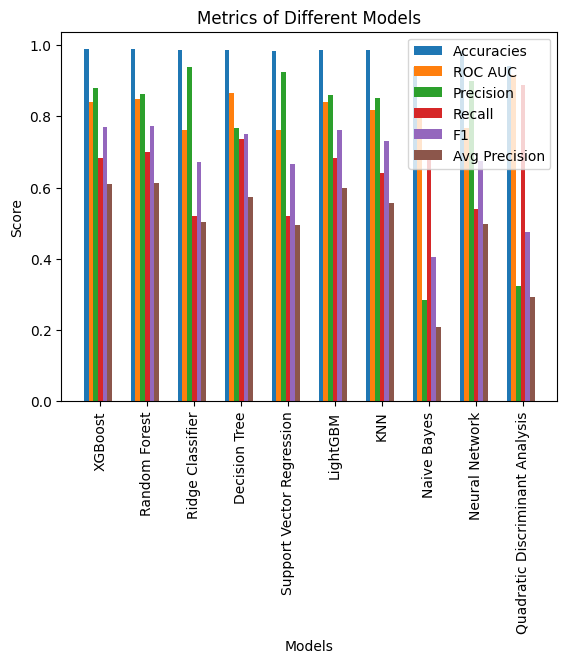

In [27]:
plot_model_results(results)

## Feature importance of best performing algorthims

In [14]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [15]:
def plot_feature_importance(model, X):

    mdi_importances = pd.Series(
        model.feature_importances_, index=X.columns
    ).sort_values(ascending=True)
    ax = mdi_importances.plot.barh()
    ax.set_title("Decision Tree Feature Importances (MDI)")
    ax.figure.tight_layout()

In [16]:
def plot_permutation_importance(model, X, y):
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=2
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()

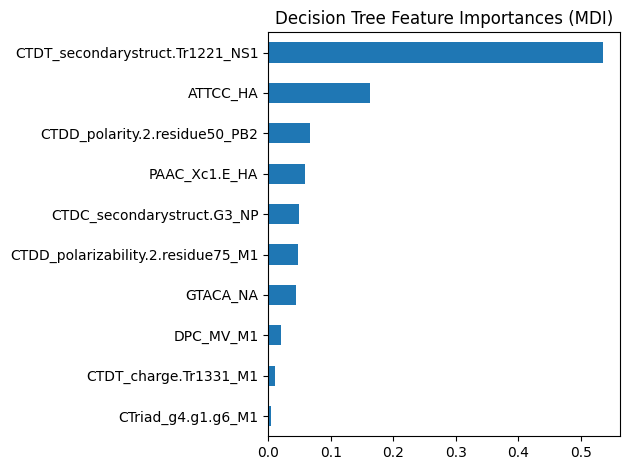

In [18]:
plot_feature_importance(model, X)

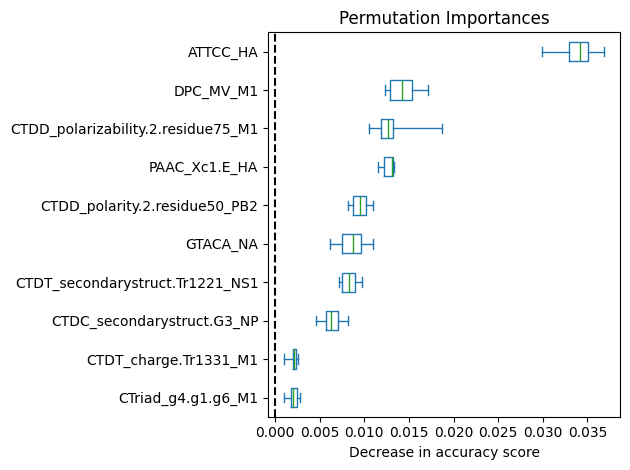

In [19]:
plot_permutation_importance(model, X_test, y_test)

## Shapley plots of best performing algorithms

In [20]:
def shapley_waterfall(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.waterfall(shap_values[20], max_display=14)


def shapley_beeswarm(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)


def shapley_heatmap(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.heatmap(shap_values[:1000])

ExactExplainer explainer: 19532it [04:31, 70.56it/s]                             


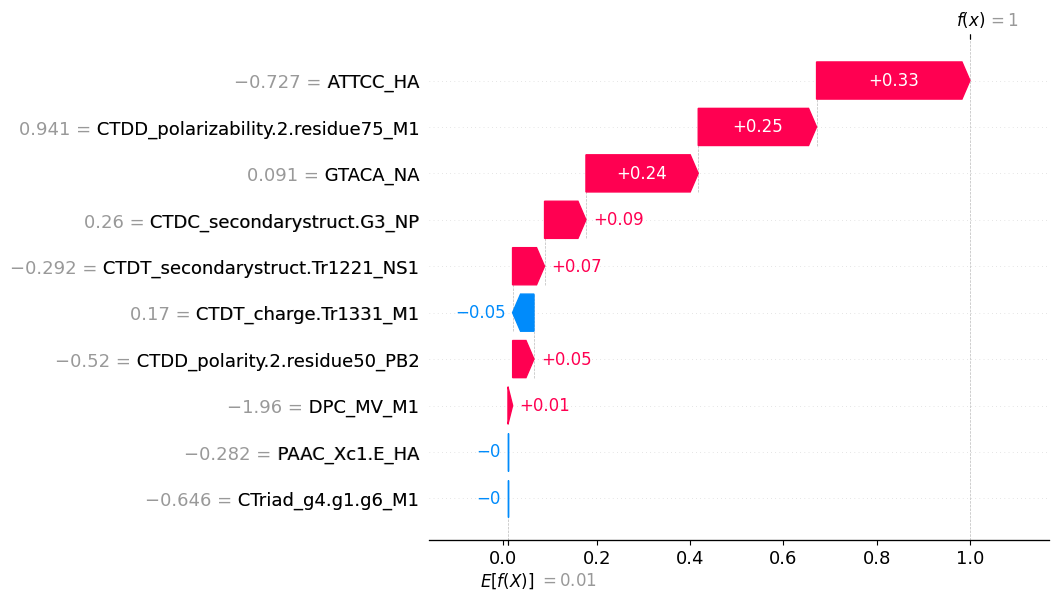

In [21]:
shapley_waterfall(model)

ExactExplainer explainer: 19532it [14:20, 21.69it/s]                             


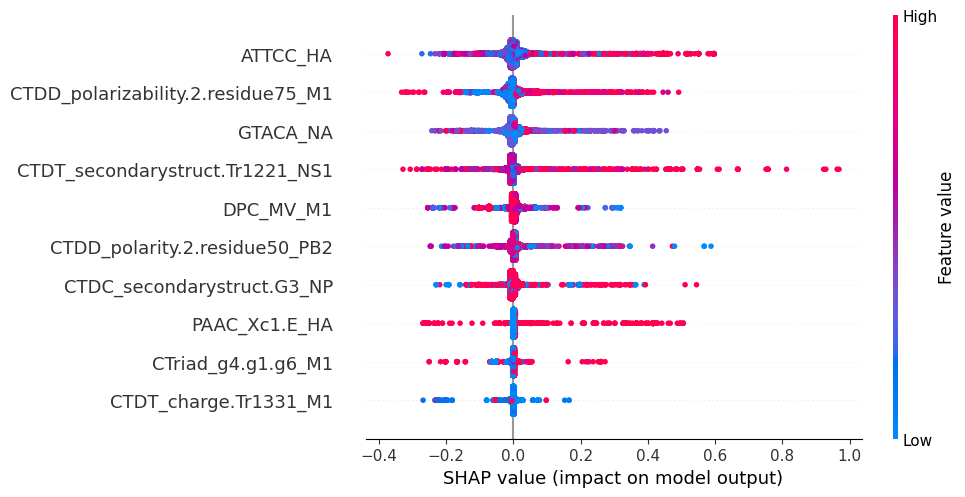

In [22]:
shapley_beeswarm(model)

ExactExplainer explainer: 19532it [03:50, 81.25it/s]                           


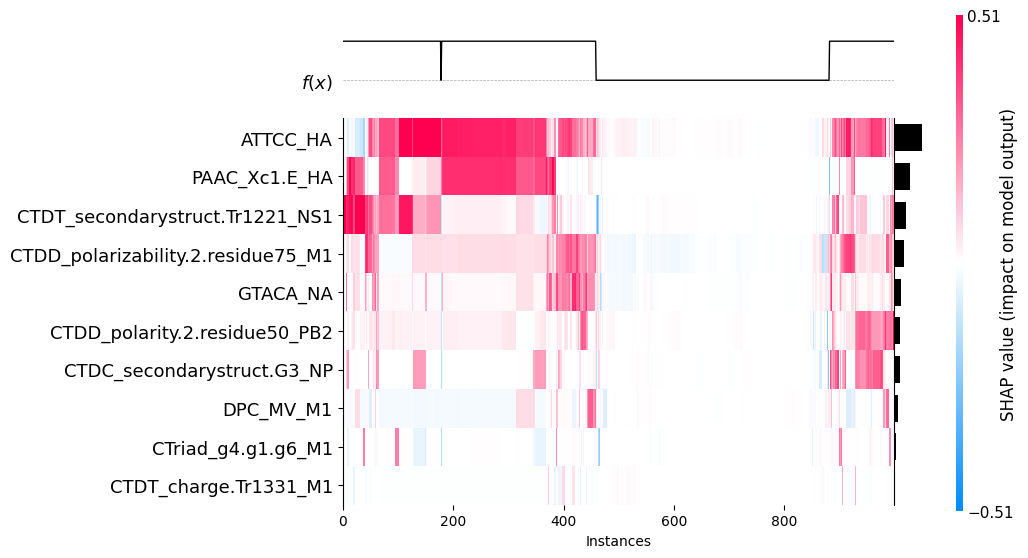

In [23]:
shapley_heatmap(model)